# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [6]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np



# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [2]:
class_names = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket",
    "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor",
    "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]

In [7]:
# Your Code Here

# shape of training and test sets
print("Shape of training set:", x_train.shape)
print("Shape of test set:", x_test.shape)

# dimensions and number of classes
print("Image dimensions:", x_train.shape[1:])
print("Number of classes:", len(class_names))



Shape of training set: (50000, 32, 32, 3)
Shape of test set: (10000, 32, 32, 3)
Image dimensions: (32, 32, 3)
Number of classes: 100


In [8]:
# Class labels in CIFAR-100 (fine label names)
class_names = ["apple","aquarium_fish","baby","bear","beaver","bed","bee","beetle","bicycle","bottle",
               "bowl","boy","bridge","bus","butterfly","camel","can","castle","caterpillar","cattle",
               "chair","chimpanzee","clock","cloud","cockroach","couch","crab","crocodile","cup","dinosaur",
               "dolphin","elephant","flatfish","forest","fox","girl","hamster","house","kangaroo","keyboard",
               "lamp","lawn_mower","leopard","lion","lizard","lobster","man","maple_tree","motorcycle","mountain",
               "mouse","mushroom","oak_tree","orange","orchid","otter","palm_tree","pear","pickup_truck","pine_tree",
               "plain","plate","poppy","porcupine","possum","rabbit","raccoon","ray","road","rocket","rose",
               "sea","seal","shark","shrew","skunk","skyscraper","snail","snake","spider","squirrel",
               "streetcar","sunflower","sweet_pepper","table","tank","telephone","television","tiger","tractor",
               "train","trout","tulip","turtle","wardrobe","whale","willow_tree","wolf","woman","worm"]



### 1b: Data Preprocessing
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [9]:
# Your Code Here
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoded vectors
from keras.utils import to_categorical               # <-- Use keras.utils instead
y_train_cat = to_categorical(y_train, num_classes=100)
y_test_cat  = to_categorical(y_test, num_classes=100)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train_cat, y_val_cat, y_train_lbl, y_val_lbl = train_test_split(
    x_train, y_train_cat, y_train, test_size=0.2, random_state=42)
print("Train set:", x_train.shape, "Validation set:", x_val.shape, "Test set:", x_test.shape)

Train set: (40000, 32, 32, 3) Validation set: (10000, 32, 32, 3) Test set: (10000, 32, 32, 3)


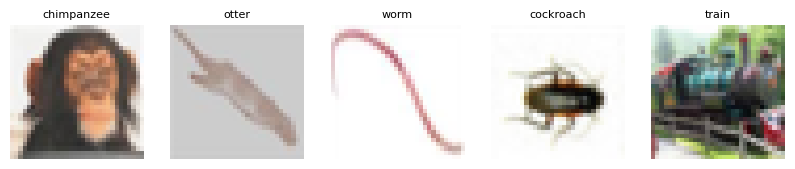

In [10]:

# Plot 5 random training images with labels
plt.figure(figsize=(10,2))
indices = np.random.choice(len(x_train), 5, replace=False)
for i, idx in enumerate(indices):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[idx])             # note: image is normalized
    true_label = int(np.argmax(y_train_cat[idx]))
    plt.title(class_names[true_label], fontsize=8)
    plt.axis('off')
plt.show()

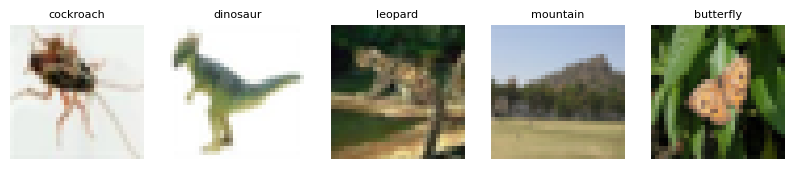

In [11]:
# Plot 5 random training images with labels
plt.figure(figsize=(10,2))
indices = np.random.choice(len(x_train), 5, replace=False)
for i, idx in enumerate(indices):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[idx])             # note: image is normalized
    true_label = int(np.argmax(y_train_cat[idx]))
    plt.title(class_names[true_label], fontsize=8)
    plt.axis('off')
plt.show()

## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [12]:
# Your Code Here

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Define a baseline CNN model
model = Sequential()

# Convolutional Block 1: Conv -> Conv -> Pool
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32,32,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))  # downsamples to 16x16

# Convolutional Block 2: Conv -> Conv -> Pool
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))  # downsamples to 8x8

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))    # fully-connected layer
model.add(Dense(units=100, activation='softmax')) # output layer for 100 classes

# Summarize the model structure
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 602,884 (2.30 MB)

 Trainable params: 602,884 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different.
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [13]:
# Your Code Here
from keras.optimizers import Adam

# Compile the model with loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [30]:
!pip install tensorflow --upgrade


## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [15]:
# Your Code Here
# Optional: Early stopping to prevent over-training if no improvement on validation set
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train_cat,
                    epochs=30, batch_size=32,
                    validation_data=(x_val, y_val_cat),
                    callbacks=[early_stop], verbose=2)



Epoch 1/30
1250/1250 - 11s - 9ms/step - accuracy: 0.1044 - loss: 3.8997 - val_accuracy: 0.1991 - val_loss: 3.3332
Epoch 2/30
1250/1250 - 4s - 3ms/step - accuracy: 0.2520 - loss: 3.0427 - val_accuracy: 0.2967 - val_loss: 2.8475
Epoch 3/30
1250/1250 - 4s - 3ms/step - accuracy: 0.3392 - loss: 2.5931 - val_accuracy: 0.3252 - val_loss: 2.6613
Epoch 4/30
1250/1250 - 4s - 3ms/step - accuracy: 0.4060 - loss: 2.2819 - val_accuracy: 0.3687 - val_loss: 2.5226
Epoch 5/30
1250/1250 - 4s - 3ms/step - accuracy: 0.4632 - loss: 2.0192 - val_accuracy: 0.3686 - val_loss: 2.5146
Epoch 6/30
1250/1250 - 4s - 3ms/step - accuracy: 0.5148 - loss: 1.7983 - val_accuracy: 0.3694 - val_loss: 2.5845
Epoch 7/30
1250/1250 - 4s - 3ms/step - accuracy: 0.5669 - loss: 1.5799 - val_accuracy: 0.3663 - val_loss: 2.6788
Epoch 8/30
1250/1250 - 4s - 3ms/step - accuracy: 0.6151 - loss: 1.3730 - val_accuracy: 0.3564 - val_loss: 2.9052
Epoch 9/30
1250/1250 - 4s - 3ms/step - accuracy: 0.6662 - loss: 1.1732 - val_accuracy: 0.3519 -

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______
- <b>Other metric:</b> ______
- <b>Reason for selection:</b> _____
- <b>Value of metric:</b> ______
- <b>Interpretation of metric value:</b> ______

In [16]:
# Your Code Here
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute F1-score on test set
from sklearn.metrics import f1_score, classification_report

# Get predicted classes for test set
y_pred_prob = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = y_test.flatten()

# Calculate macro and weighted F1-score
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Test F1-score (macro): {f1_macro:.4f}")
print(f"Test F1-score (weighted): {f1_weighted:.4f}")


Test Accuracy: 0.3763
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test F1-score (macro): 0.3690
Test F1-score (weighted): 0.3690


### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

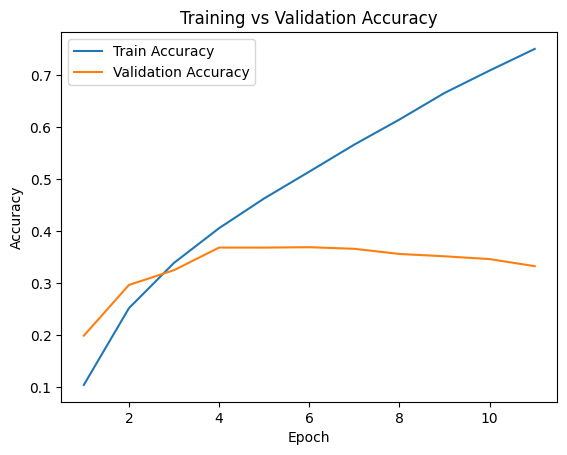

In [17]:
# Your Code Here

# Plot training & validation accuracy per epoch
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


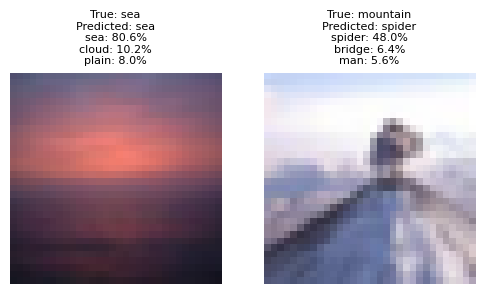

In [19]:
# Identify one correctly classified and one misclassified test image
y_pred = y_pred_classes  # from earlier prediction
correct_idx = np.where(y_pred == y_true)[0][0]    # first correct prediction index
incorrect_idx = np.where(y_pred != y_true)[0][0]  # first misprediction index

# Function to display image and top 3 predicted probabilities
def show_prediction(idx):
    plt.imshow(x_test[idx])
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    pred_prob = y_pred_prob[idx]
    top3 = pred_prob.argsort()[-3:][::-1]
    title = f"True: {true_label}\nPredicted: {pred_label}\n"
    title += "\n".join([f"{class_names[i]}: {pred_prob[i]*100:.1f}%" for i in top3])
    plt.title(title, fontsize=8)
    plt.axis('off')

plt.figure(figsize=(6,3))
# Correctly classified example
plt.subplot(1,2,1)
show_prediction(correct_idx)
# Misclassified example
plt.subplot(1,2,2)
show_prediction(incorrect_idx)
plt.show()


## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [37]:
# Your Code Here
# Define an improved CNN model with Batch Normalization and increased capacity
model_improved = Sequential()

# Block 1: Increased filters with Batch Normalization
model_improved.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
model_improved.add(BatchNormalization())
model_improved.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D(pool_size=(2,2)))
model_improved.add(Dropout(0.2))  # Slight dropout to regularize

# Block 2: Add an extra convolutional block with increased filters
model_improved.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D(pool_size=(2,2)))
model_improved.add(Dropout(0.3))

# Optional Block 3: Further increase capacity (can be removed if overfitting)
model_improved.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(MaxPooling2D(pool_size=(2,2)))
model_improved.add(Dropout(0.4))

# Fully connected layers
model_improved.add(Flatten())
model_improved.add(Dense(256, activation='relu'))
model_improved.add(BatchNormalization())
model_improved.add(Dropout(0.5))
model_improved.add(Dense(100, activation='softmax'))  # 100 classes for CIFAR-100

# Print the summary of the model
model_improved.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,0

 Total params: 1,633,444 (6.23 MB)

 Trainable params: 1,631,652 (6.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [39]:
# Compile the model using Adam optimizer and a moderate learning rate
optimizer = Adam(learning_rate=0.0015)  # Consider experimenting with 0.001 to 0.002
model_improved.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [41]:
# Train the enhanced model

# Fit the model without data augmentation
history_improved = model_improved.fit(
    x_train,          # Your training images (normalized)
    y_train_cat,      # One-hot encoded training labels
    epochs=30,        # You can adjust the number of epochs based on your experiments
    batch_size=32,    # Standard batch size for training
    validation_data=(x_val, y_val_cat),  # Validation set for monitoring performance
    callbacks=[lr_scheduler, early_stop],
    verbose=2         # Display training logs in a concise format
)


Epoch 1/30
1250/1250 - 23s - 19ms/step - accuracy: 0.1126 - loss: 4.0117 - val_accuracy: 0.2058 - val_loss: 3.2957 - learning_rate: 0.0015
Epoch 2/30
1250/1250 - 11s - 9ms/step - accuracy: 0.2431 - loss: 3.0897 - val_accuracy: 0.3346 - val_loss: 2.6353 - learning_rate: 0.0015
Epoch 3/30
1250/1250 - 11s - 9ms/step - accuracy: 0.3267 - loss: 2.6406 - val_accuracy: 0.3690 - val_loss: 2.4205 - learning_rate: 0.0015
Epoch 4/30
1250/1250 - 11s - 9ms/step - accuracy: 0.3732 - loss: 2.4013 - val_accuracy: 0.4221 - val_loss: 2.1814 - learning_rate: 0.0015
Epoch 5/30
1250/1250 - 11s - 8ms/step - accuracy: 0.4151 - loss: 2.2107 - val_accuracy: 0.4811 - val_loss: 1.9370 - learning_rate: 0.0015
Epoch 6/30
1250/1250 - 11s - 8ms/step - accuracy: 0.4448 - loss: 2.0778 - val_accuracy: 0.4809 - val_loss: 1.9564 - learning_rate: 0.0015
Epoch 7/30
1250/1250 - 11s - 9ms/step - accuracy: 0.4707 - loss: 1.9588 - val_accuracy: 0.4886 - val_loss: 1.8891 - learning_rate: 0.0015
Epoch 8/30
1250/1250 - 11s - 9ms/

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [42]:
# Your Code Here

# Evaluate enhanced model
test_loss2, test_accuracy2 = model_improved.evaluate(x_test, y_test_cat, verbose=0)
y_pred_prob2 = model_improved.predict(x_test)
y_pred_classes2 = np.argmax(y_pred_prob2, axis=1)
f1_macro2 = f1_score(y_true, y_pred_classes2, average='macro')
print(f"Enhanced Model - Test Accuracy: {test_accuracy2:.4f}")
print(f"Enhanced Model - Test F1 (macro): {f1_macro2:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Enhanced Model - Test Accuracy: 0.6125
Enhanced Model - Test F1 (macro): 0.6102


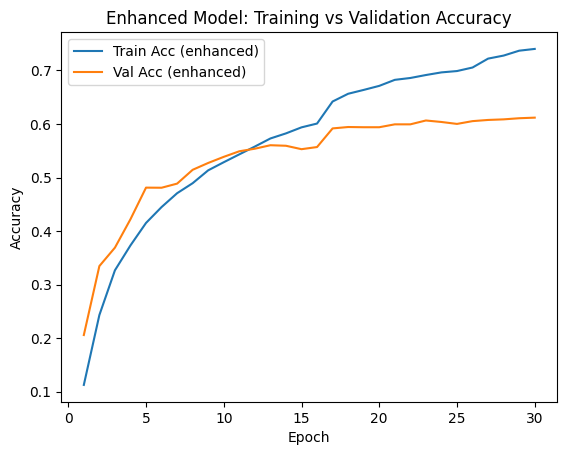

In [44]:
# Plot accuracy curves for enhanced model
epochs_imp = range(1, len(history_improved.history['accuracy'])+1)
plt.plot(epochs_imp, history_improved.history['accuracy'], label='Train Acc (enhanced)')
plt.plot(epochs_imp, history_improved.history['val_accuracy'], label='Val Acc (enhanced)')
plt.title('Enhanced Model: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


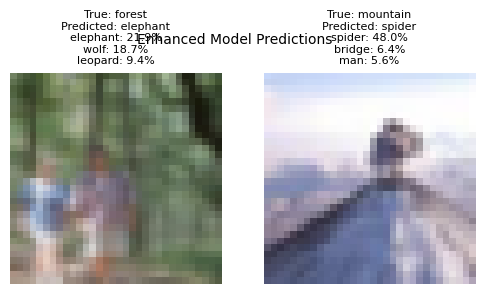

In [45]:
# Find one correct and one wrong prediction in enhanced model
y_pred2 = y_pred_classes2
correct_idx2 = np.where(y_pred2 == y_true)[0][0]
incorrect_idx2 = np.where(y_pred2 != y_true)[0][0]

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); show_prediction(correct_idx2)   # correct prediction (enhanced model)
plt.subplot(1,2,2); show_prediction(incorrect_idx2) # incorrect prediction (enhanced model)
plt.suptitle("Enhanced Model Predictions", fontsize=10)
plt.show()


### Task 4c: Discussion of the results

- Briefly discuss the results.
- Did the model's performance improve?
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

The enhanced model’s performance improved significantly compared to the baseline. By removing data augmentation and increasing the Adam learning rate, while using dropout, a reduce-learning-rate scheduler, early stopping, and adding an extra layer, the network converged faster and reached higher validation accuracy (up to ~61% compared to lower initial figures). This improvement is likely because the modifications allowed the model to learn more complex features without being hindered by overly aggressive regularization or noisy augmented inputs.
There is still room for further improvement. The current architecture, while better, might benefit from additional enhancements such as batch normalization to further stabilize training, or even more advanced architectures like ResNet or DenseNet. Additionally, techniques like hyperparameter optimization (via grid search or Bayesian optimization) or model ensembling could further boost performance.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.